In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import random

def set_seed(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [3]:
seed = 1234
set_seed(seed)

In [4]:
class CosineDataset(Dataset):
    def __init__(self, x_0, x_1, x_2, y):
        self.x_0 = x_0
        self.x_1 = x_1
        self.x_2 = x_2
        self.y = y

    def __len__(self):
        return len(self.x_0)

    def __getitem__(self, idx):
        return self.x_0[idx], self.x_1[idx], self.x_2[idx], self.y[idx]

In [5]:
class CosineDataGenerator:
    def __init__(self, num_samples=3000, n_ancilla=3, multiplicity=10, ratio=0.8):
        assert num_samples % 5 == 0, "num_samples must be a multiple of 5"
        self.num_samples = num_samples
        self.n_ancilla = n_ancilla
        self.multiplicity = multiplicity
        self.ratio = ratio
        self.delta = math.pi / (2 * 3 * num_samples)  # Step size

        # Precompute datasets
        self.train_data = self._generate_sequence('train')
        self.test_data = self._generate_sequence('test')

    def _generate_sequence(self, dataset_type):
        if dataset_type == 'train':
            start = 0
            end = self.ratio * (math.pi / 2) - 4 * self.delta
            steps = int(self.ratio * self.num_samples)
        else:
            start = self.ratio * (math.pi / 2)
            end = math.pi / 2 - 4 * self.delta
            steps = self.num_samples - int(self.ratio * self.num_samples)

        x0_data = torch.linspace(start, end, steps)
        x1_data = x0_data + 1 * self.delta
        x2_data = x0_data + 2 * self.delta
        x3_data = x0_data + 3 * self.delta

        input_seq_0 = torch.cos(self.multiplicity * x0_data.unsqueeze(-1))
        input_seq_1 = torch.cos(self.multiplicity * x1_data.unsqueeze(-1))
        input_seq_2 = torch.cos(self.multiplicity * x2_data.unsqueeze(-1))

        target_seq = torch.stack([
            torch.cos(self.multiplicity * (x0_data + i * self.delta)) for i in range(1, 4)
        ], dim=1)  # Shape: [steps, 3]

        return input_seq_0, input_seq_1, input_seq_2, target_seq

    def get_loaders(self, batch_size=32):
        train_dataset = CosineDataset(*self.train_data)
        test_dataset = CosineDataset(*self.test_data)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        return train_loader, test_loader

In [6]:
generator = CosineDataGenerator()
train_loader, test_loader = generator.get_loaders(batch_size=64)

In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, num_layers=1, nonlinearity='tanh'):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          nonlinearity=nonlinearity,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self._init_weights()

    def _init_weights(self):
        # Initialize RNN weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.uniform_(param, a=-0.6, b=0.6)
            elif 'bias' in name:
                nn.init.zeros_(param)

        # Initialize Linear layer
        nn.init.uniform_(self.fc.weight, a=-0.6, b=0.6)
        nn.init.zeros_(self.fc.bias)


    def forward(self, x_0, x_1, x_2):

        out_0, h_0 = self.rnn(x_0)
        out_0 = self.fc(out_0)

        out_1, h_1 = self.rnn(x_1, h_0)
        out_1 = self.fc(out_1)

        out_2, _ = self.rnn(x_2, h_1)
        out_2 = self.fc(out_2)

        combined_out = torch.stack([out_0, out_1, out_2], dim=1).squeeze(-1)  # [batch_size, 3]

        return combined_out


In [8]:
model = RNNModel(input_dim=1, hidden_dim=19, output_dim=1)

In [9]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=5*1e-2)

In [10]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_params(model))

438


In [11]:
# Test random function
model.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2]) # test only given x0 x1 x2, predict x3
        test_loss_y2 += loss_y2.item()
        num_batch += 1

    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Test Loss before Training (all steps): {test_loss_all:.4f}")
print(f"\n Test Loss before Training (3rd step): {test_loss_y2:.4f}")



 Test Loss before Training (all steps): 0.7434

 Test Loss before Training (3rd step): 0.6351


In [12]:
loss_history = []

In [13]:
# Training
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    num_batch = 0

    for batch_x_0, batch_x_1, batch_x_2, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x_0, batch_x_1, batch_x_2)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batch += 1
    epoch_loss /= num_batch
    #if epoch%10 == 0:
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/100 - Loss: 0.2389
Epoch 2/100 - Loss: 0.0343
Epoch 3/100 - Loss: 0.0159
Epoch 4/100 - Loss: 0.0126
Epoch 5/100 - Loss: 0.0105
Epoch 6/100 - Loss: 0.0076
Epoch 7/100 - Loss: 0.0071
Epoch 8/100 - Loss: 0.0063
Epoch 9/100 - Loss: 0.0054
Epoch 10/100 - Loss: 0.0052
Epoch 11/100 - Loss: 0.0039
Epoch 12/100 - Loss: 0.0040
Epoch 13/100 - Loss: 0.0035
Epoch 14/100 - Loss: 0.0042
Epoch 15/100 - Loss: 0.0042
Epoch 16/100 - Loss: 0.0039
Epoch 17/100 - Loss: 0.0028
Epoch 18/100 - Loss: 0.0028
Epoch 19/100 - Loss: 0.0025
Epoch 20/100 - Loss: 0.0026
Epoch 21/100 - Loss: 0.0025
Epoch 22/100 - Loss: 0.0022
Epoch 23/100 - Loss: 0.0022
Epoch 24/100 - Loss: 0.0020
Epoch 25/100 - Loss: 0.0020
Epoch 26/100 - Loss: 0.0022
Epoch 27/100 - Loss: 0.0022
Epoch 28/100 - Loss: 0.0022
Epoch 29/100 - Loss: 0.0019
Epoch 30/100 - Loss: 0.0017
Epoch 31/100 - Loss: 0.0017
Epoch 32/100 - Loss: 0.0016
Epoch 33/100 - Loss: 0.0016
Epoch 34/100 - Loss: 0.0014
Epoch 35/100 - Loss: 0.0020
Epoch 36/100 - Loss: 0.0016
E

In [14]:
#Evaluation
model.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0
x_3_list = []
y_2_list = []

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2])
        test_loss_y2 += loss_y2.item()

        x_3_list.append(output[:, 2].tolist())
        y_2_list.append(batch_y[:, 2].tolist())

        num_batch += 1
    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Final test Loss (all steps): {test_loss_all:.4f}")
print(f"\n Final test Loss (3rd step): {test_loss_y2:.4f}")


 Final test Loss (all steps): 0.0012

 Final test Loss (3rd step): 0.0010


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [16]:
n_steps = len(loss_history)

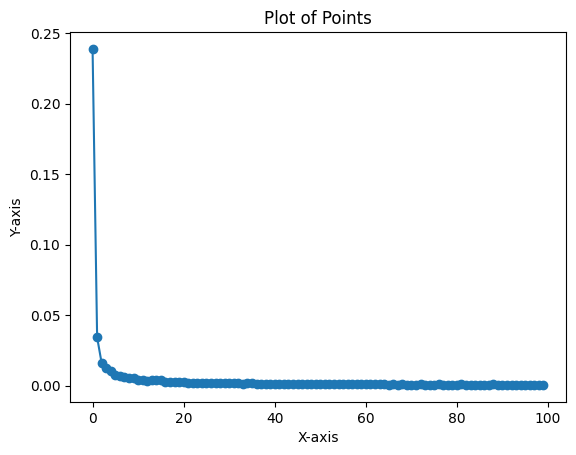

In [17]:

x_coords = [i for i in range(n_steps)]
y_coords = loss_history

plt.plot(x_coords, y_coords, c="#1f77b4", marker="o")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Points')
plt.show()

In [18]:
print(loss_history)

[0.23888198247081355, 0.03425844003887553, 0.015891706889593286, 0.012645480124966094, 0.010516955455961196, 0.0075574154279341825, 0.007143191117058067, 0.006297541059259521, 0.005369406003554009, 0.005151823500024253, 0.0039370516498916245, 0.00404532952234149, 0.00347450161720381, 0.004181866050011625, 0.004202967448356121, 0.003931028988996619, 0.00284898047041344, 0.0027827617565267964, 0.002521022431258308, 0.0025563400949498542, 0.0024954220126873175, 0.0021554277535822046, 0.002182923965033536, 0.001968128900778921, 0.0020260180371176255, 0.0021558655824169123, 0.0021571705123948817, 0.002152121083590349, 0.0018629479516101511, 0.00170447022997235, 0.0017125418526120484, 0.0015740557052930327, 0.0015747828078211139, 0.0013806985899511921, 0.0019950769186068916, 0.001575347147943256, 0.0014902044341923964, 0.0012936747072289062, 0.0012603077354326256, 0.0012381275239596633, 0.0013681587420011822, 0.0014372455832352372, 0.001121890721965189, 0.0013679835859588103, 0.0011539538268

In [19]:
print(x_3_list)

[[0.9552996158599854, 0.9559017419815063, 0.9556805491447449, 0.9533573389053345, 0.9519680738449097, 0.9520367383956909, 0.9518892168998718, 0.9516968727111816, 0.9515747427940369, 0.9513811469078064, 0.9511299729347229, 0.950871467590332, 0.9505913257598877, 0.9502856731414795, 0.9499583840370178, 0.9496088624000549, 0.949236273765564, 0.9488410949707031, 0.948423445224762, 0.9479827284812927, 0.9475197792053223, 0.9470338225364685, 0.9465253949165344, 0.9459943175315857, 0.9454402327537537, 0.9448641538619995, 0.9442649483680725, 0.9436432719230652, 0.9429988265037537, 0.9423319697380066, 0.9416422247886658, 0.9409303069114685, 0.9401954412460327, 0.9394378662109375, 0.9386581182479858, 0.9378553628921509, 0.9370298981666565, 0.93618243932724, 0.9353123903274536, 0.9344191551208496, 0.9335039854049683, 0.9325658082962036, 0.9316055774688721, 0.9306224584579468, 0.9296169281005859, 0.9285889267921448, 0.9275382161140442, 0.9264649748802185, 0.9253697991371155, 0.924251914024353, 0.92

In [20]:
print(y_2_list)

[[0.9999862909317017, 0.9999452233314514, 0.9998767375946045, 0.9997808933258057, 0.9996576309204102, 0.9995070099830627, 0.9993290305137634, 0.9991236925125122, 0.9988909363746643, 0.998630940914154, 0.9983434677124023, 0.9980287551879883, 0.9976866841316223, 0.9973171949386597, 0.9969205856323242, 0.9964964985847473, 0.9960452318191528, 0.9955666065216064, 0.9950607419013977, 0.9945275783538818, 0.9939674139022827, 0.9933797717094421, 0.9927650690078735, 0.9921231269836426, 0.9914539456367493, 0.9907578229904175, 0.9900343418121338, 0.9892838597297668, 0.9885061979293823, 0.9877015352249146, 0.9868696928024292, 0.9860112071037292, 0.9851253032684326, 0.9842126369476318, 0.9832730293273926, 0.9823063015937805, 0.98131263256073, 0.9802924990653992, 0.9792453646659851, 0.978171169757843, 0.9770703911781311, 0.9759426712989807, 0.9747886061668396, 0.9736074805259705, 0.972399890422821, 0.971165657043457, 0.9699046015739441, 0.9686169624328613, 0.9673032760620117, 0.9659628868103027, 0.96

In [21]:
file_path = 'simple_model.pth'
torch.save(model.state_dict(), file_path)

In [22]:
model1 = RNNModel(input_dim=1, hidden_dim=19, output_dim=1)
model1.load_state_dict(torch.load(file_path))
model1.eval()

RNNModel(
  (rnn): RNN(1, 19, batch_first=True)
  (fc): Linear(in_features=19, out_features=1, bias=True)
)

In [23]:
#Evaluation
model1.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0
output_list = []
y_list = []

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model1(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2])
        test_loss_y2 += loss_y2.item()

        output_list.append(output.tolist())
        y_list.append(batch_y.tolist())

        num_batch += 1
    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Final test Loss (all steps): {test_loss_all:.4f}")
print(f"\n Final test Loss (3rd step): {test_loss_y2:.4f}")


 Final test Loss (all steps): 0.0012

 Final test Loss (3rd step): 0.0010


In [24]:
print(output_list)

[[[1.1159275770187378, 0.955274224281311, 0.9552996158599854], [1.1769912242889404, 0.9558782577514648, 0.9559017419815063], [1.031538724899292, 0.9556678533554077, 0.9556805491447449], [1.0102288722991943, 0.9533748626708984, 0.9533573389053345], [0.9980117082595825, 0.952006459236145, 0.9519680738449097], [0.9130732417106628, 0.9520809054374695, 0.9520367383956909], [0.8825007677078247, 0.9519408941268921, 0.9518892168998718], [0.9371827840805054, 0.9517562389373779, 0.9516968727111816], [0.9568063020706177, 0.9516410827636719, 0.9515747427940369], [0.9509595632553101, 0.9514548182487488, 0.9513811469078064], [0.952144980430603, 0.9512113332748413, 0.9511299729347229], [0.952538788318634, 0.9509603977203369, 0.950871467590332], [0.9506765007972717, 0.9506878852844238, 0.9505913257598877], [0.9502918720245361, 0.9503896236419678, 0.9502856731414795], [0.950219988822937, 0.9500698447227478, 0.9499583840370178], [0.9498390555381775, 0.9497279524803162, 0.9496088624000549], [0.9494643211

In [25]:
print(y_list)

[[[0.9999985098838806, 0.9999939203262329, 0.9999862909317017], [0.9999756813049316, 0.9999619722366333, 0.9999452233314514], [0.999925434589386, 0.999902606010437, 0.9998767375946045], [0.9998478293418884, 0.9998158812522888, 0.9997808933258057], [0.999742865562439, 0.9997017979621887, 0.9996576309204102], [0.9996105432510376, 0.9995602965354919, 0.9995070099830627], [0.9994508028030396, 0.9993914365768433, 0.9993290305137634], [0.9992637038230896, 0.9991952180862427, 0.9991236925125122], [0.999049186706543, 0.9989715814590454, 0.9988909363746643], [0.998807430267334, 0.9987207055091858, 0.998630940914154], [0.9985381960868835, 0.9984423518180847, 0.9983434677124023], [0.9982417225837708, 0.9981367588043213, 0.9980287551879883], [0.997917890548706, 0.997803807258606, 0.9976866841316223], [0.9975666403770447, 0.997443437576294, 0.9973171949386597], [0.9971882104873657, 0.9970559477806091, 0.9969205856323242], [0.9967823624610901, 0.9966409802436829, 0.9964964985847473], [0.996349275112